<a href="https://colab.research.google.com/github/marcinwolter/MedicalPictures/blob/master/figure_cnn_recoMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code generating geometrical figures (circles, triangles, squeres) and performing pattern recognition using Deep NN

*Dec. 2019, Marcin Wolter*

In [21]:
'''Trains a simple convnet on the generated set of figures (circle, triangle, square)
'''
from __future__ import print_function

#install KERAS if not there
!pip install keras_sequential_ascii

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import metrics

from PIL import Image, ImageDraw

import time
import math


# **Setup the parameters**

In [0]:
# DNN parameters
batch_size = 128
num_classes = 3
epochs = 256 #12

np.random.seed(2348)

batch_size_gen = 60000
batch_size_val = 10000

# input image dimensions
img_rows, img_cols = 32, 32
img_shape = (img_rows, img_cols)


#probability of noise and its max. brithness 
prob_noise = 1.0
ampl_noise = 0.3


# figure min and max brithness
fig_min_gray=0.4
fig_max_gray=0.9

#figure sizes
# circle radius
rmin = 0.10
rmax = 0.25
# triangle/rectangle size
dmin = 0.10
dmax = 0.30
# distortion - smearing sigma
sigma = (1.8,1.8)

# **Generate noise**

In [0]:
def gen_noise(batch_size_gen=batch_size_gen, img_shape=img_shape, prob_noise=prob_noise):

        batch_events = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        for n in range(batch_size_gen):

            for i in range(img_shape[0]):
               for j in range(img_shape[1]):
                 if np.random.random()<prob_noise:
                     batch_events[n,0,i,j]= min(1.,max(0.,ampl_noise*np.random.randn()))


        yield batch_events


#  Generate geometrical figures - circle, triangle, square

In [0]:

### generate geometrical figures

def generate_circle(r, x0, y0, img_shape):
    """
    Generate a single circle.
    Parameters:
        r: radius
        x0,y0: position of the circle center
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 10x10 pixels, 1 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.ellipse((x0-r, y0-r, x0+r, y0+r), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255
    
    #print(x)
    return x

In [0]:
def generate_square(d, x0, y0, angle, img_shape):
    """
    Generate a square.
    Parameters:
        d: size
        x0,y0: position of the square center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel
    draw = ImageDraw.Draw(image)
    draw.rectangle((x0-d/2, y0-d/2, x0+d/2, y0+d/2), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255

      
    #print(x)
    return x




In [0]:
def generate_triangle(d, x0, y0, angle, img_shape):
    """
    Generate a triangle.
    Parameters:
        d: size 
        x0,y0: position of the triangle center
        angle: rotation angle
        img_shape: image shape (depth, width)
    Returns:
        ndarray data for one figure.
    """

    image = Image.new('L', img_shape) #create new image, 32x32 pixels, 8 bit per pixel grayscale
    draw = ImageDraw.Draw(image)
    dd = d/math.sqrt(3)
    draw.polygon(((x0-d/2, y0-dd/2), (x0+d/2, y0-dd/2), (x0,y0+dd)), fill = np.random.randint(int(255*fig_min_gray),int(255*fig_max_gray)))
    image = image.rotate(angle)
    #print(list(image.getdata()))
    #image.show()
    x = np.array(image)/255.
    
    #print(x)
    return x



In [0]:


# generate a random number
def rand_interval(a = 0., b = 1.):
   rnd = a + (b-a)*np.random.random()
   return rnd


# **Random figure generator**

In [0]:
# Generator for random figures
# Each image contains exactly one object (circle, triangle, square)
def gen_n_figures(batch_size_gen=batch_size_gen, img_shape=img_shape):

        batch_events  = np.zeros((batch_size_gen, 1, img_shape[0], img_shape[1]))
        batch_targets =-np.ones((batch_size_gen, 1, 1 ))

        for n in range(batch_size_gen):
            
            k = np.random.randint(0,3)
            
            r = rand_interval(img_cols*rmin, img_cols*rmax)
            d = rand_interval(img_cols*dmin, img_cols*dmax) 
            l = rand_interval(img_cols*dmin, img_cols*dmax)
            x0 = rand_interval(0.33*img_cols, 0.66*img_cols)       
            y0 = rand_interval(0.33*img_rows, 0.66*img_rows)     
            alpha = 360.*np.random.random()  

            if k == 0:
               batch_events[n,0] = generate_circle(r, x0, y0, img_shape)
            elif k == 1:
               batch_events[n,0] = generate_square(d, x0, y0, alpha, img_shape)
            elif k == 2:
               batch_events[n,0] = generate_triangle(l, x0, y0, alpha, img_shape)
            else:
               print("Wrong figure id!!!")
            batch_targets[n,0] = k
            


        yield batch_events, batch_targets



# **Distort an image** (now bluring)

In [0]:
# Distort images
from scipy import ndimage
def distort_n_figures(images,  img_shape=img_shape, sigma = sigma):
  
  images_distorted = np.zeros((len(images), 1, img_shape[0], img_shape[1]))
  for n in range(len(images)):
     
    
    images_distorted[n,0] = ndimage.gaussian_filter(255.*images[n,0], sigma=sigma)/255.
#    images_distorted[n,0] = images[n,0]

  return images_distorted

# **Generate training and test data**

In [0]:
#generate training and validation dataset
xx_train, yy_train = next(gen_n_figures(batch_size_gen, img_shape))
xx_test, yy_test   = next(gen_n_figures(batch_size_val, img_shape))
xx_val, yy_val     = next(gen_n_figures(batch_size_val, img_shape))


# add noise
xx_train = xx_train + next(gen_noise(batch_size_gen, img_shape))
xx_test  = xx_test  + next(gen_noise(batch_size_val, img_shape))
xx_val   = xx_val  + next(gen_noise(batch_size_val, img_shape))

#and distort an image
xx_train = distort_n_figures(xx_train)
xx_test  = distort_n_figures(xx_test)
xx_val   = distort_n_figures(xx_val)

#and clip to get maximum 1
xx_train = np.clip(xx_train, 0, 1)
xx_test  = np.clip(xx_test, 0, 1)
xx_val   = np.clip(xx_val, 0, 1)



Plot some figures

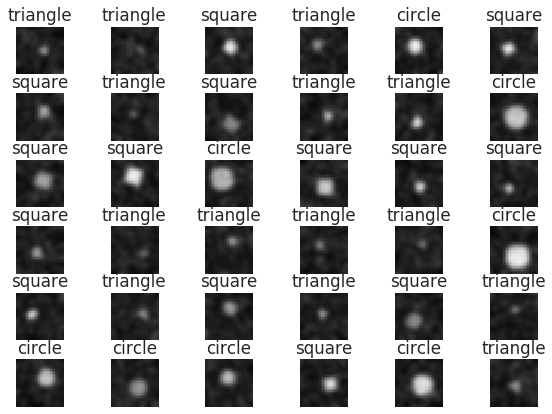

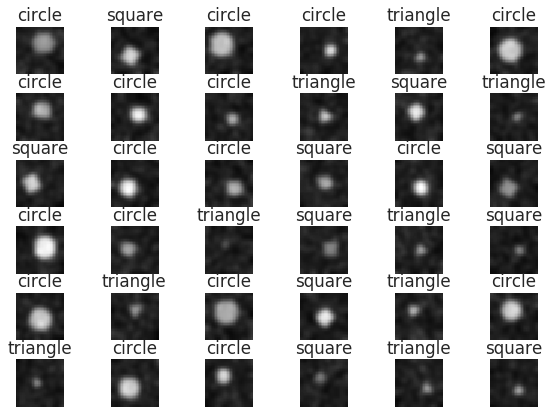

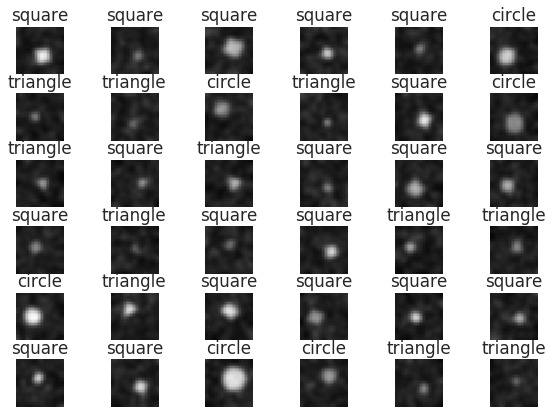

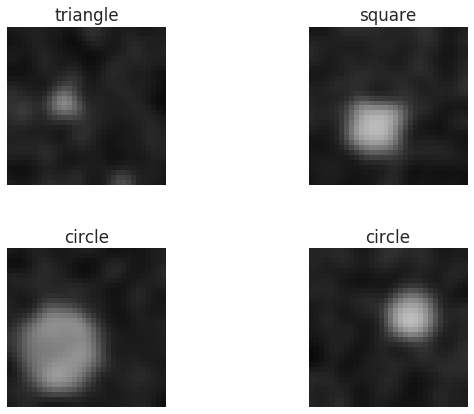

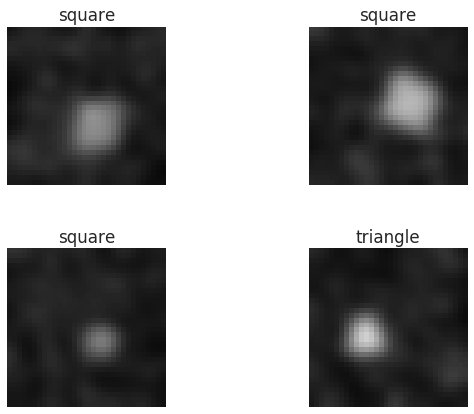

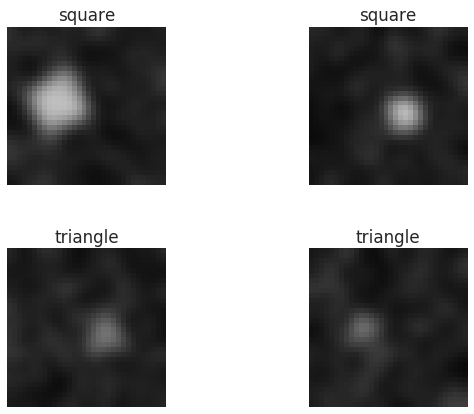

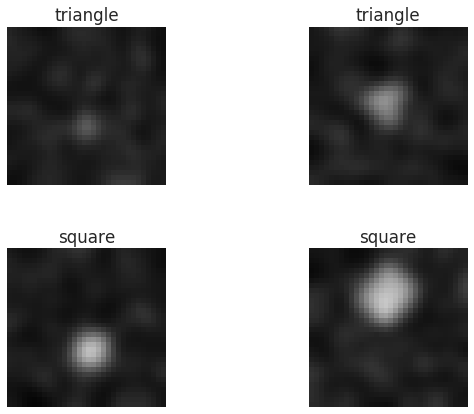

In [31]:

#plot 100 figures (random offset)
class_names = ['circle','square','triangle']


def plot_images(plot_size=6):
  offset = max(0, min(batch_size_gen-plot_size*plot_size, np.random.randint(0,batch_size_gen/2)))
  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for n in range(min(plot_size*plot_size,len(xx_train))):
    ax = plt.subplot(plot_size, plot_size, n+1)
    ax.imshow(xx_train[n+offset,0], cmap='gray', vmin=0, vmax=1)
    ax.set_title(class_names[int(yy_train[n+offset,0])])
    ax.axis('off')

  plt.show()
  #plt.savefig('event.png')
  #plt.clf()
  
plot_images(6)
plot_images(6)
plot_images(6)
plot_images(2)
plot_images(2)
plot_images(2)
plot_images(2)

In [32]:
# Convert and pre-processing

yy_train = np_utils.to_categorical(yy_train, num_classes)
yy_test = np_utils.to_categorical(yy_test, num_classes)
yy_val = np_utils.to_categorical(yy_val, num_classes)

print("yy_train ",yy_train.shape)



yy_train  (60000, 1, 3)


**Define the Deep Neural Network**

In [0]:
# Define Model

def base_model():

    model = Sequential()
    input_shape=(1,img_rows,img_cols)

    model.add(Reshape((img_rows,img_cols,1),input_shape=input_shape))


    model.add(Conv2D(img_rows, (3, 3), padding='same', activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(img_rows,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(2*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(Dropout(rate = 0.2))

    model.add(Conv2D(4*img_rows,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))
    model.add(Dense(32*img_rows,activation='relu',kernel_constraint=maxnorm(3))) #1024
    model.add(Dropout(rate = 0.3))


    model.add(Dense(num_classes, activation='softmax'))

    model.add(Reshape((1,num_classes),input_shape=(num_classes,)))

#    sgd = SGD(lr = 0.1, decay=1e-6, nesterov=True)
    sgd = SGD(lr = 0.01, decay=1e-6, nesterov=True)

# Train model

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[metrics.categorical_accuracy])   # 'accuracy'
    return model



Visualize DNN

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)       

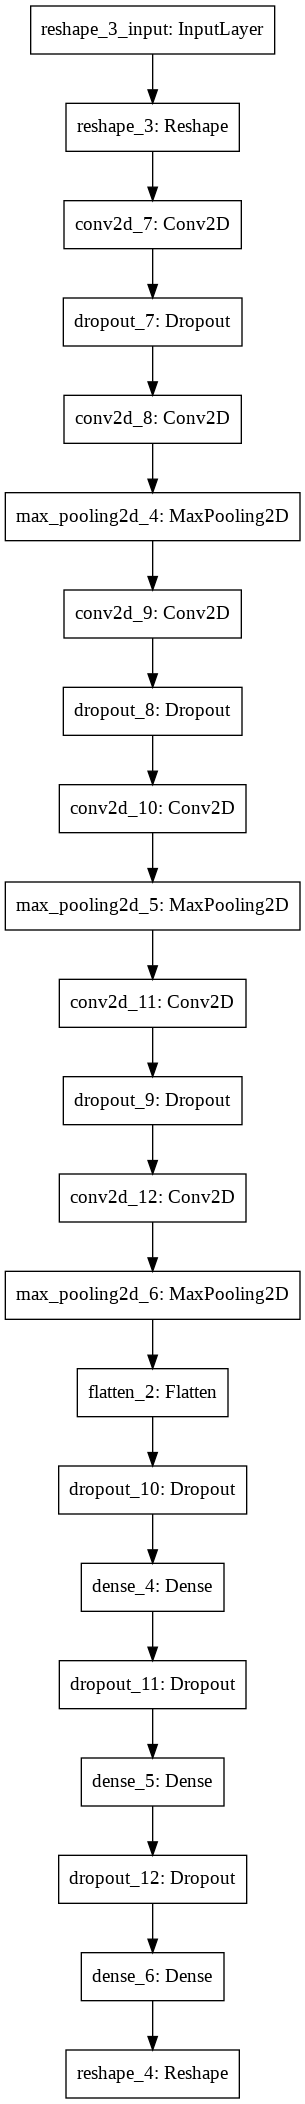

In [34]:
# Vizualizing model structure
# Model summary (ascii)
cnn_n = base_model()
cnn_n.summary()

# Model printout (ascii)
sequential_model_to_ascii_printout(cnn_n)

# Plotting model in graphical mode
plot_model(cnn_n)   ###, to_file='model.png')  ###, show_shapes=True



# **Train DNN (early stopping defined)**

In [0]:


# patient early stopping
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
cnn = cnn_n.fit(xx_train, yy_train, batch_size=batch_size, epochs=epochs, validation_data=(xx_test,yy_test),shuffle=True, callbacks=[es, mc])
# load the saved model
saved_model = load_model('best_model.h5')





Train on 60000 samples, validate on 10000 samples
Epoch 1/256
60000/60000 [==============================] - 22s 364us/step - loss: 0.9515 - categorical_accuracy: 0.5058 - val_loss: 0.8507 - val_categorical_accuracy: 0.5900

Epoch 00001: val_categorical_accuracy improved from -inf to 0.59000, saving model to best_model.h5
Epoch 2/256
60000/60000 [==============================] - 20s 339us/step - loss: 0.7552 - categorical_accuracy: 0.6277 - val_loss: 0.9057 - val_categorical_accuracy: 0.5654

Epoch 00002: val_categorical_accuracy did not improve from 0.59000
Epoch 3/256
60000/60000 [==============================] - 21s 344us/step - loss: 0.7375 - categorical_accuracy: 0.6294 - val_loss: 0.7959 - val_categorical_accuracy: 0.6146

Epoch 00003: val_categorical_accuracy improved from 0.59000 to 0.61460, saving model to best_model.h5
Epoch 4/256
60000/60000 [==============================] - 20s 338us/step - loss: 0.7293 - categorical_accuracy: 0.6307 - val_loss: 0.8017 - val_categorical_

# **Evaluate the DNN**

In [0]:
#
# evaluate loaded model
scores_train = saved_model.evaluate(xx_train, yy_train, verbose=0)
scores_test  = saved_model.evaluate(xx_test,  yy_test,  verbose=0)
scores_val   = saved_model.evaluate(xx_val,   yy_val,   verbose=0)
print("Accuracy Train: %.2f%% , Test: %.2f%% Val: %.2f%% " % (scores_train[1]*100, scores_test[1]*100, scores_val[1]*100))

# **Plot training results**

In [0]:


# Plots for training and testing process: loss and accuracy

n_epochs = len(cnn.history['loss'])

plt.figure(0)
plt.plot(cnn.history['categorical_accuracy'],'r')
plt.plot(cnn.history['val_categorical_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Cat_Accuracy vs Validation Cat_Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()




# **Draw confussion matrix**

In [0]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
YY_pred = saved_model.predict(xx_val, verbose=2)
yy_pred = np.argmax(YY_pred, axis=2)

yy_test2 = np.argmax(yy_test, axis=2)



#confusion matrix
cm = confusion_matrix(np.argmax(yy_val,axis=2),yy_pred)
print(cm)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(num_classes),
                  range(num_classes))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


Plot some results

In [0]:

def plot_results(plot_size=6):
  
  offset = max(0, min(len(YY_pred)-plot_size*plot_size, np.random.randint(0,len(YY_pred)/2)))

  plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.90, wspace=0.20, hspace=0.40)
  for i in range(int(min(plot_size/2,len(YY_pred)/plot_size))):
    for n in range(int(min(plot_size,len(YY_pred)))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+n+1 )
      ax.imshow(xx_val[plot_size*i+n+offset,0], cmap='gray', vmin=0, vmax=1)
      ax.axis('off')

    for n in range(min(plot_size,len(YY_pred))):
      ax = plt.subplot(plot_size,plot_size,plot_size*2*i+plot_size+n+1)
      x = np.arange(3)
      ax.bar(x, height = YY_pred[plot_size*i+n+offset,0], tick_label = class_names) 
      ax.axis('off')
#      ax.set_title(class_names[int(np.argmax(YY_pred,axis=2)[plot_size*i+n+offset])])
      ax.set_title(class_names[int(np.argmax(yy_val,axis=2)[plot_size*i+n+offset])])
#      print("yy_val",np.argmax(yy_val,axis=2))
#      print("YY_pred",np.argmax(YY_pred,axis=2))
  
  plt.show()
  #plt.savefig('event.png')
  #plt.clf()


plot_results(6)
plot_results(6)
plot_results(6)
plot_results(6)
plot_results(6)

plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)
plot_results(2)




# **The end**